# All imports

In [76]:
import pandas as pd
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from pickle import dump, load
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn import tree

# Importing data

In [77]:
url='https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv'

house_raw=pd.read_csv(url)

# Data exploration

**Data description**

*   MedInc median income in block group
*   HouseAge median house age in block group
*   AveRooms average number of rooms per household
*   AveBedrms average number of bedrooms per household
*   Population block group population
*   AveOccup average number of household members
*   Latitude block group latitude
*   Longitude block group longitude

More info here: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

In [78]:
house_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


*   Median income seems to be expressed in thousands of dollars. The average median income is about 3,800 USD
*   The average rooms and bedrooms seems to have very high values, which is expected given that the documentation mentions that this is occurs because some census areas are vacation resorts
*   The variable population has a extreme value of about 35K people. This is likely an outlier since the data documentation says a census block typically has between 300 and 3,000 people. 

In [79]:
house_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


# Univariate analysis

**Distribution of variables:**

*  The distribution of most variables seems mostly smooth
*  The average rooms and bedrooms, as described earlier, has extreme values
*  The AveOccup (average number of household members) seems to also have extreme values. This is could be, or could not, related to the inclusion of vacation resorts in census areas 
*  There are roughly 1,000 areas with a MedHouseVal of about 5. Not sure if these are normal values or outliers or a data entry error

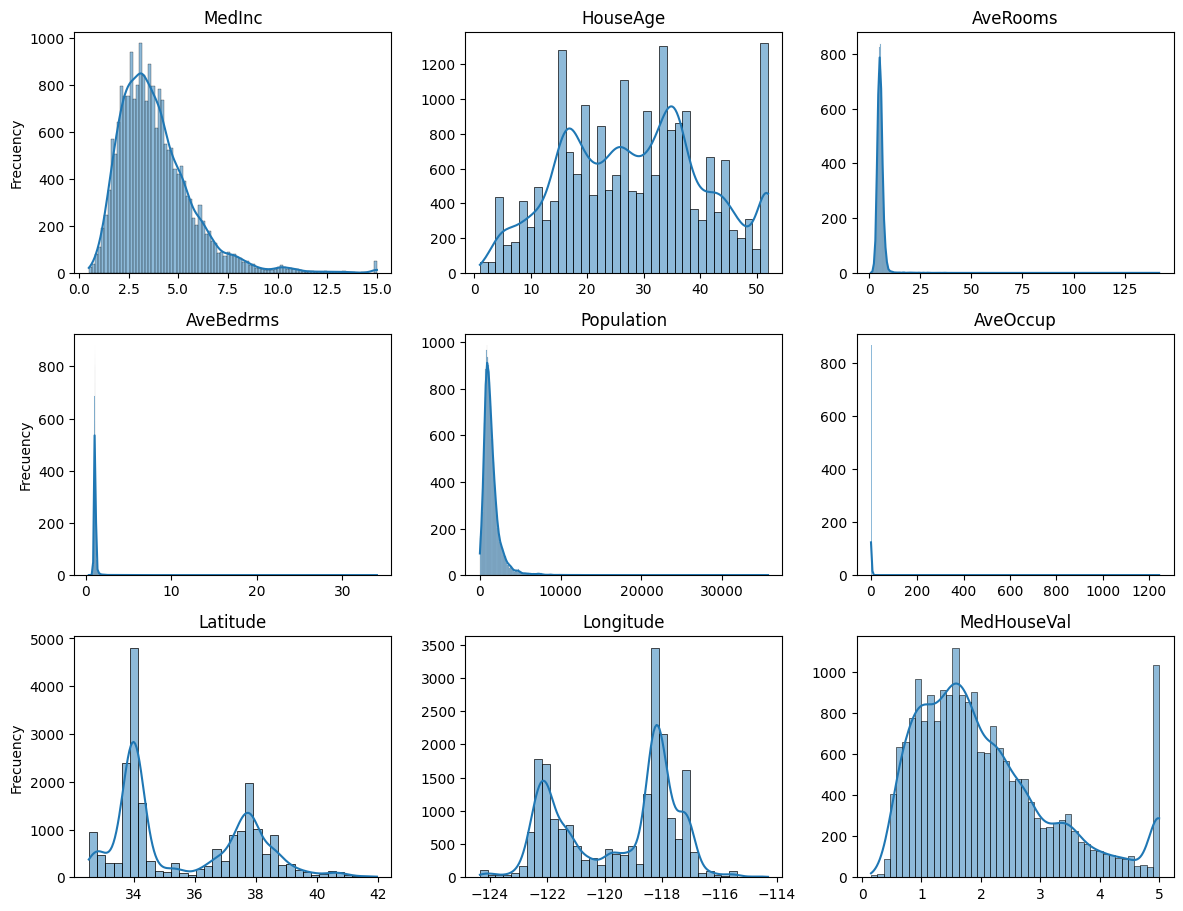

In [80]:
cols=3
rows=(len(house_raw.columns) // cols) + 1
fig, axis = plt.subplots(rows, cols, figsize=(12, rows * 3))

for col, ax in zip(house_raw.columns , axis.flatten()):
  sns.histplot(house_raw[col], kde=True, ax=ax)
  ax.set_title(col)
  ax.set_ylabel('')
  ax.set_xlabel('')

axis[0,0].set_ylabel('Frecuency')
axis[1,0].set_ylabel('Frecuency')
axis[2,0].set_ylabel('Frecuency')

#removing empty subplots, if there are any
for i in range(len(house_raw.columns), len(axis.flatten())):
      fig.delaxes(axis.flatten()[i])

plt.tight_layout()
plt.show()

MedHouseVal has 992 outliers

In [81]:
house_raw[house_raw['MedHouseVal']>=5]['MedHouseVal'].describe()

count    992.000000
mean       5.000010
std        0.000002
min        5.000000
25%        5.000010
50%        5.000010
75%        5.000010
max        5.000010
Name: MedHouseVal, dtype: float64

# Multivariate analysis

**Relationship between variables:**

The pairplot allows to better assess the state of outliers in the data for each variable:
*   Values of AveRooms above 100 
*   Values of AveBedrms above 20
*   Values of Population above 25,000
*   Values of AveOccup above 100
*   MedHouseVal seems more problematic as there seems to be several observations concentrated around the value of 5

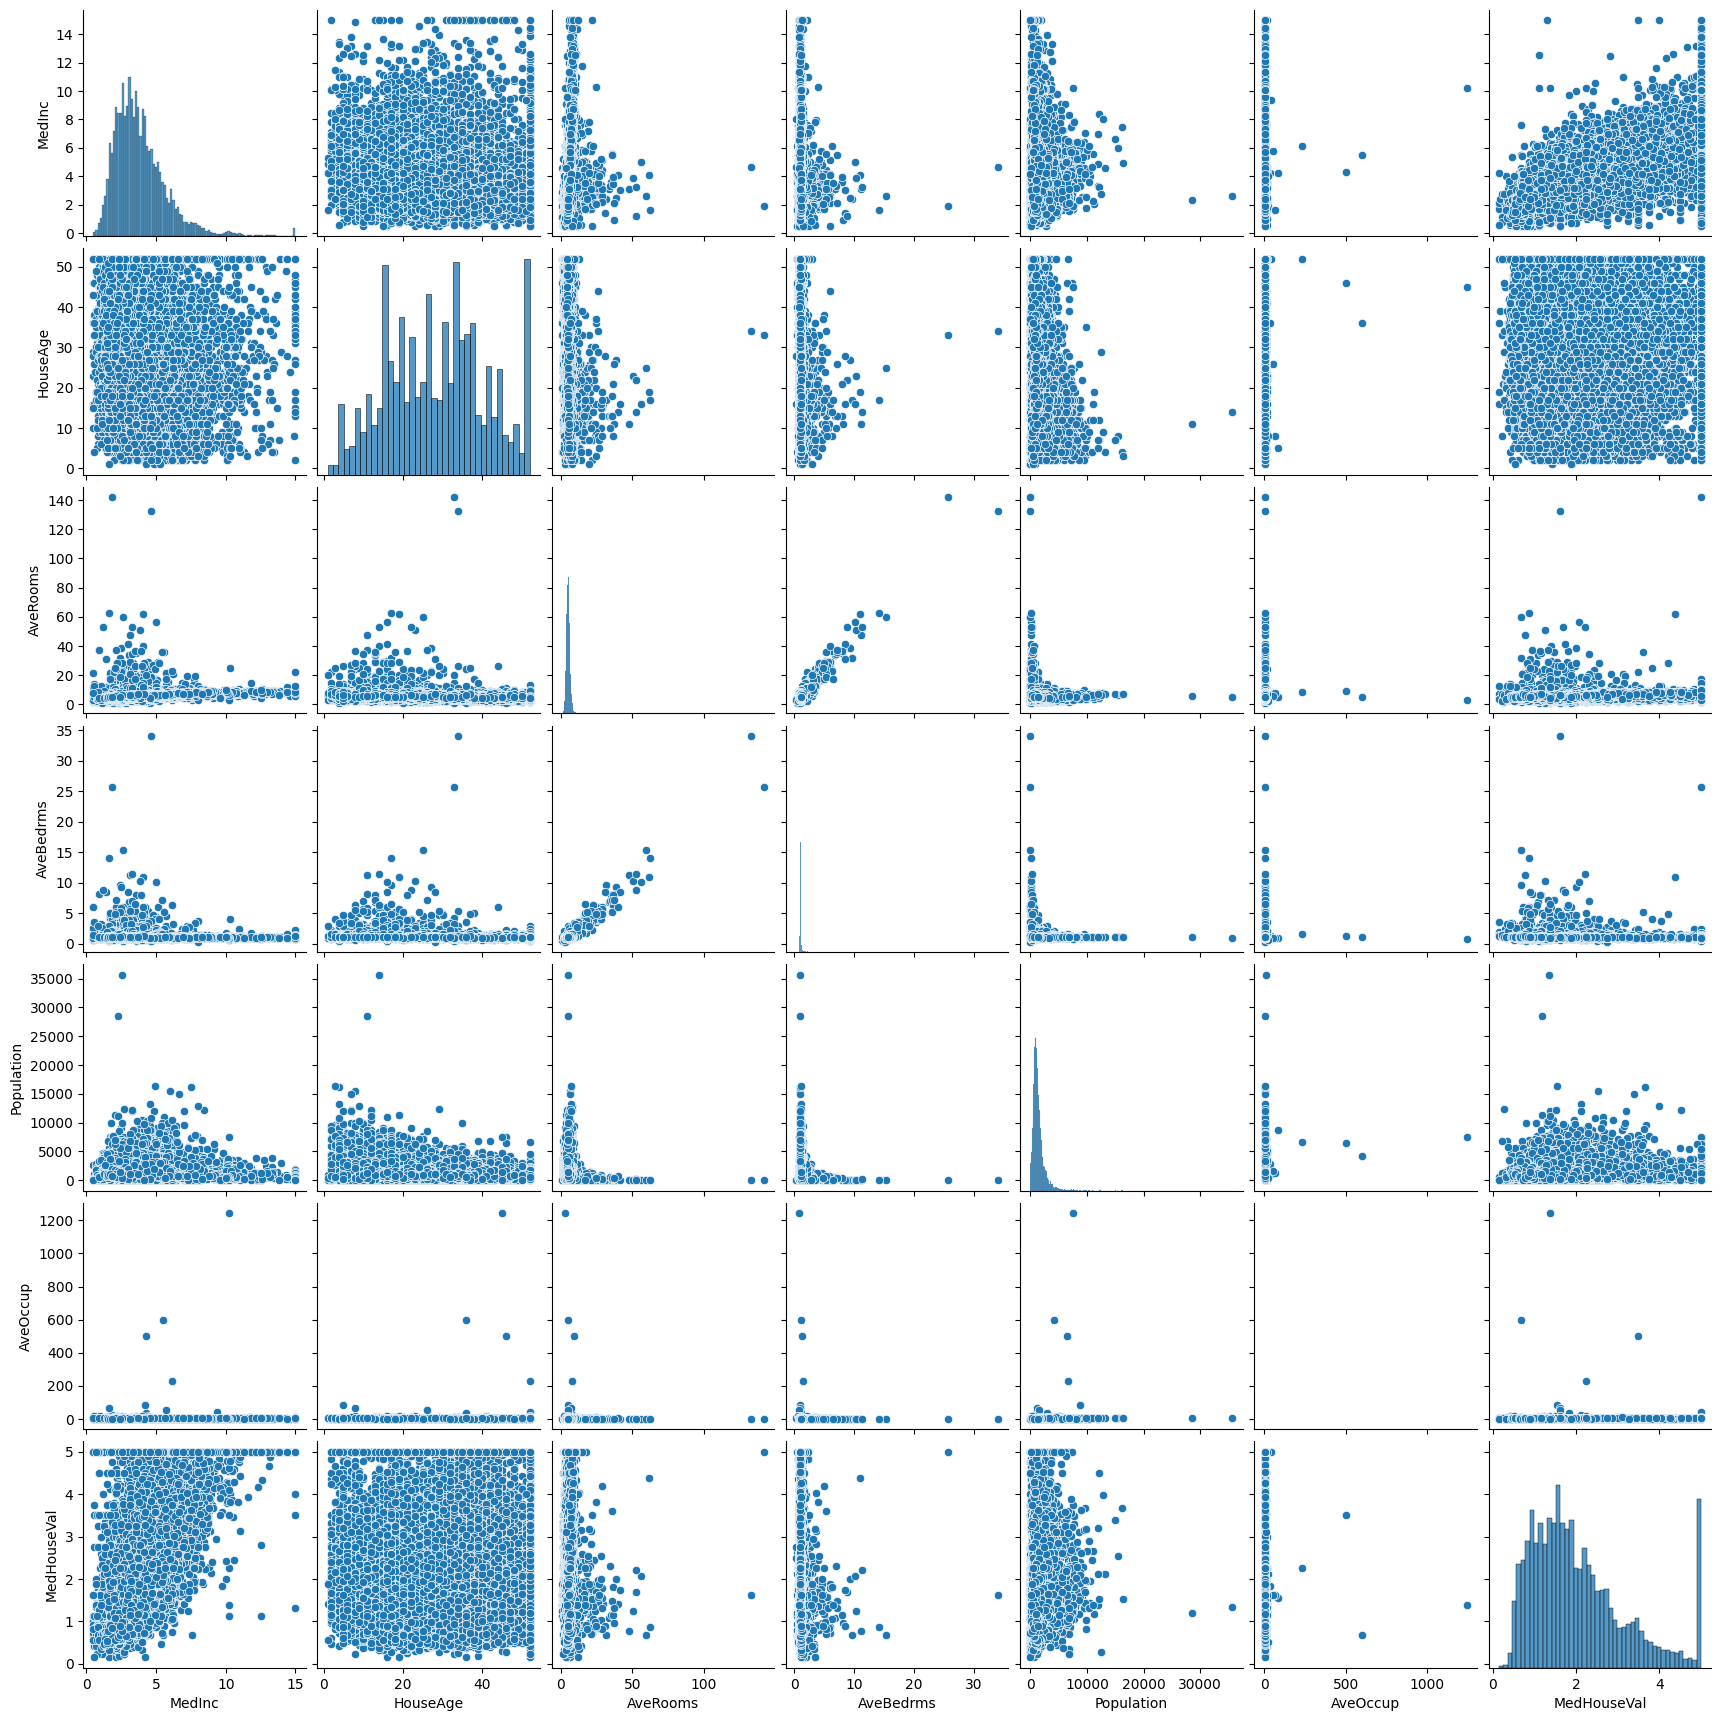

In [82]:
sns.pairplot(house_raw.drop(['Latitude','Longitude'], axis=1), corner=False)
plt.show()

Creating a new dataset without outliers but keeping outliers of MedHouseVal:

In [83]:
condition='AveRooms<100 and AveBedrms<20 and AveOccup<100 and Population<25000'
house_nout=house_raw.copy().query(condition)

print('The new data set has: ', len(house_raw)-len(house_nout),' Fewer observations compared to the original')


The new data set has:  8  Fewer observations compared to the original


The outliers of median house value do not seem to behave differently or to change the relationship with the remaining variables. It could be that these values belong to areas with sigificantly higher house values, something that is expected in california.

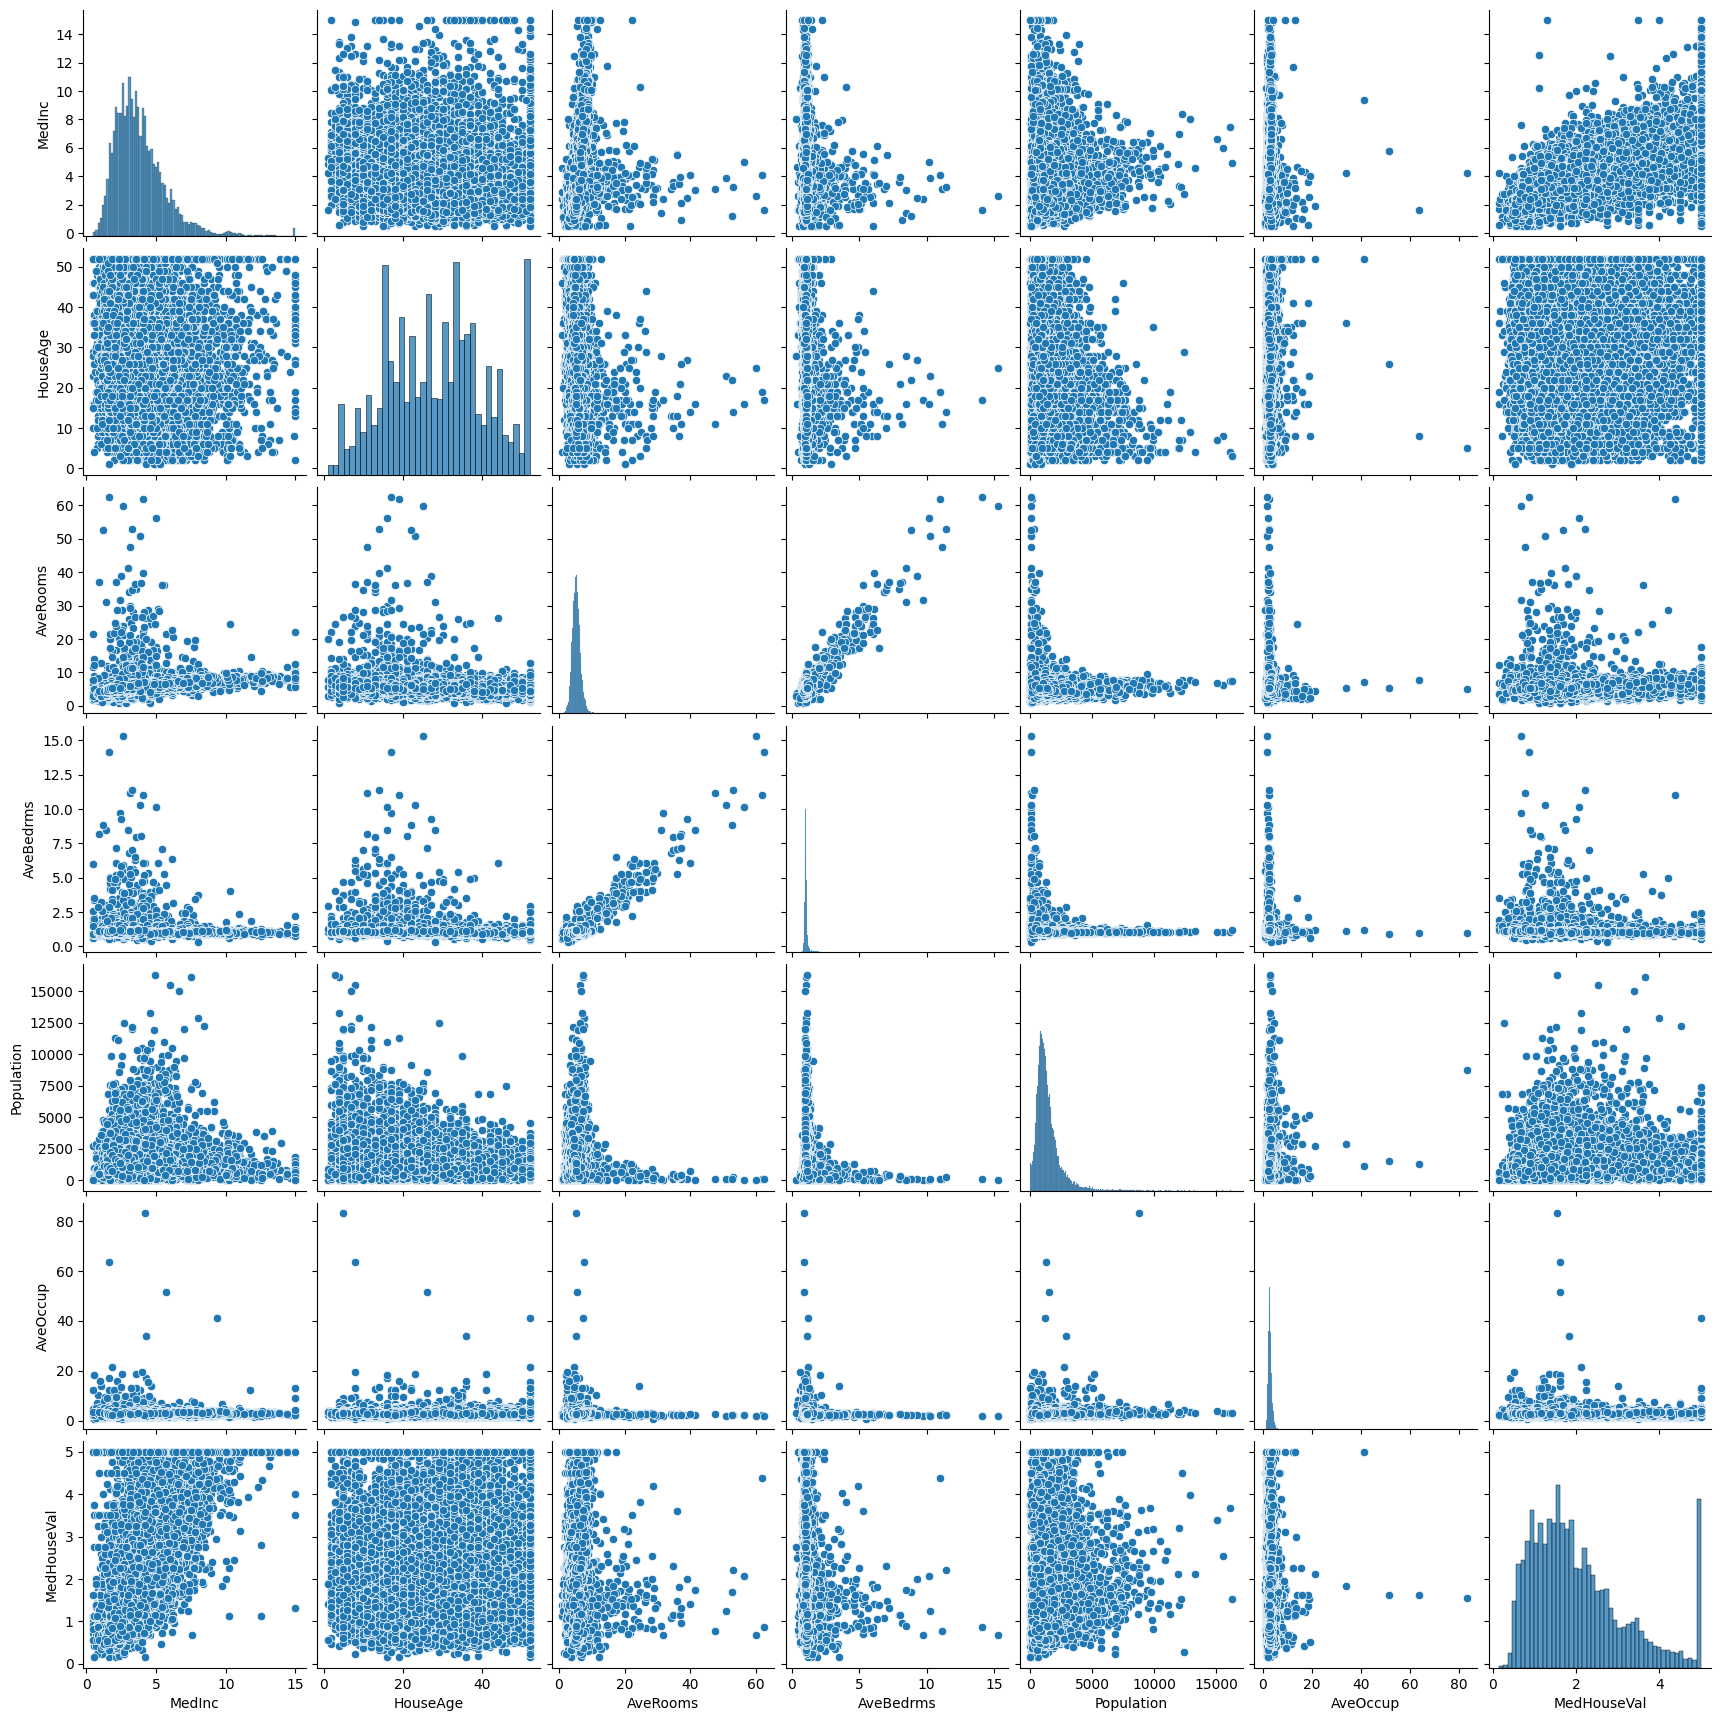

In [84]:
sns.pairplot(house_nout.drop(['Latitude','Longitude'], axis=1), corner=False)
plt.show()

Correlation matrix with and without extreme values:

* The correlations do not seem to change significantly after removing outliers
* Average bedrooms and rooms are higly correlated, which is expected
* There is a mild strong association between median income and median house value, which is expected, areas with a higher median income can afford more expensive homes.



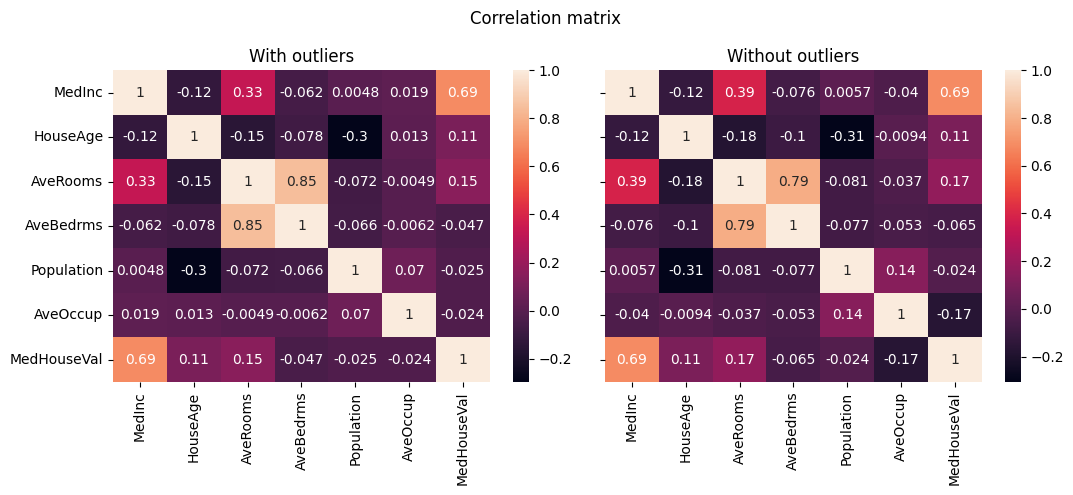

In [85]:
fig, axis = plt.subplots(1,2, figsize=(11,5))
sns.heatmap(house_raw.drop(['Latitude','Longitude'], axis=1).corr(), annot=True, ax=axis[0])
sns.heatmap(house_nout.drop(['Latitude','Longitude'], axis=1).corr(), annot=True, ax=axis[1])

axis[0].set_title('With outliers')
axis[1].set_title('Without outliers')
axis[1].set_yticklabels('')

plt.suptitle('Correlation matrix')
plt.tight_layout()
plt.show()



# Splitting data into train and test

In this unsupervised model, the test data will be used to make predictions about new data points. Only the variables latitude, longitude, and median income will be kept since these are the focus of the project

In [86]:
X_train, X_test = train_test_split(house_nout[['MedInc','Latitude','Longitude']], test_size=0.2, random_state=42)

In [87]:
X_train.head(3)

,MedInc,Latitude,Longitude
6247,3.5179,34.05,-117.97
9383,5.4851,37.91,-122.50
6108,2.8547,34.13,-117.88


In [88]:
X_test.head(3)

,MedInc,Latitude,Longitude
13862,2.1875,34.41,-117.25
1710,4.2348,37.99,-122.31
9281,6.9081,38.09,-122.61


Storing datasets

In [89]:
X_train.to_csv('/workspaces/Kmeans_housing/data/processed/X_train', index_label=False)
X_test.to_csv('/workspaces/Kmeans_housing/data/processed/X_test', index_label=False)